# Boosting Black Box Variational Inference
## Introduction
This tutorial demonstrates how to implement boosting black box variational inference in Pyro. In comparison to standard variational inference, boosting VI approximates the target density with a mixture of density functions rather than a single density. It thus offers an easy way of getting more complex approximation of distributions in siutations where a single density doesn't approximate the target well enough.


## Theoretical Background

### Variational Inference
For an introduction to standard Variational Inference, we recommend first checking out [the tutorial on SVI in Pyro](https://pyro.ai/examples/svi_part_i.html).
Recall that in standard Variational Inference, we maximize the Evidence Lower BOund (ELBO):
$$ E_s[\text{log} p(x, z)] - E_s[\text{log} s(z)]$$

where $s(z)$ is the approximating distribution, the guide, and $p(x,z)$ the target distribution.

### Boosting Black Box Variational Inference

In the boosting BBVI, we greedily components to our approximation by maximising the Residual ELBO (RELBO):

$$E_s[\text{log} p(x,z)] - \lambda E_s[\text{log}s] - E_s[\text{log} q^t]$$

Roughly, the algorithm is thus the following:

```~python
initalize q_0
for t=1:T
  Find s_t that maximizes RELBO
  gamma = 2/(t+1)
  q_t = (1 - gamma)*q_t + gamma*s_t
  
```

where `q_t` is the approximation at time step `t`.

 
Conveniently, we do not need to make any additional assumptions about the variational family that's being used.

## BBBVI in Pyro

To implement boosting black box variational inference in Pyro, we need to consider the following three components:
- How to set up the guide and the approximation
- How to implement the RELBO
- How to run SVI and update the approximation

We will illustrate these points by looking at two examples. First, we will use BBBVI to approximate a bimodal posterior and then we'll use BBBVI for Bayesian Logistic Regression on the ChemReact data set.


### The Model

Boosting BBVI is particularly useful in situations where we're trying to approximate mulitmodal posteriors. In this tutorial, we'll thus consider the following model:
 
 $$\mu \sim \mathcal{N}(0,5)$$
 $$y \sim \mathcal{N}(\mu^2, 1)$$
 
 Observing some data points around 4, we expect $p(mu|y)$ to be a bimodal distributions with means around -2 and + 2.

In [178]:
def model(data):
    # Global variables.
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    loc = pyro.sample('loc', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([1.])

    with pyro.plate('data', len(data)):
        # Local variables.
        pyro.sample('obs', dist.Normal(loc*loc, scale), obs=data)

### The Guide

In [180]:
def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([1.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

### The RELBO

In [168]:
def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    relbo_lambda = kwargs.pop('relbo_lambda', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)



    approximation_trace = trace(replay(block(approximation, expose=['loc']), guide_trace)).get_trace(*args, **kwargs)
    # We will acculoclate the various terms of the ELBO in `elbo`.

    # This is how we computed the ELBO before using TraceEnum_ELBO:
    elbo = model_trace.log_prob_sum() - relbo_lambda * guide_trace.log_prob_sum() - approximation_trace.log_prob_sum()

    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                               guide,
                                                         *args, **kwargs)

    elbo = -loss_fn - 0.1 * approximation_trace.log_prob_sum()

    return -elbo  

### The Approximation

In [169]:
def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result        

In [170]:
def dummy_approximation(data):
    scale_q = pyro.param('scale_0', torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_0', torch.tensor([20.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

### The Greedy Algorithm

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . loc = 1.9530718326568604
scale = 0.09594951570034027
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . loc = -2.3136916160583496
scale = 0.17421917617321014


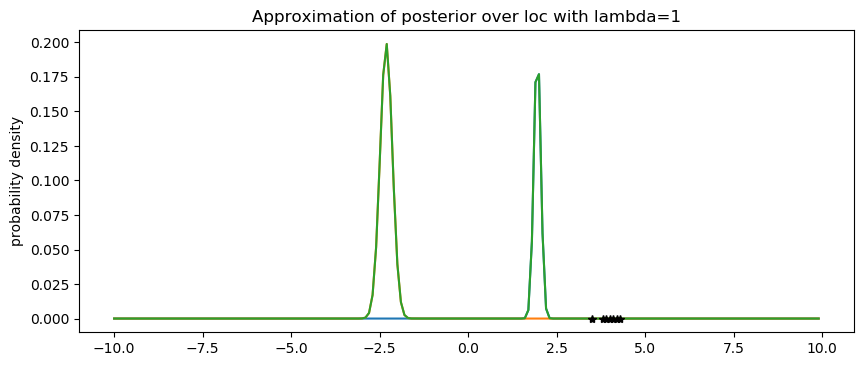

In [4]:
"""

"""
import math
import os
from collections import defaultdict
from functools import partial

import matplotlib
import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.infer.autoguide import AutoDelta
from pyro.optim import SGD, Adam
from pyro.poutine import block, replay, trace

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 10000
pyro.set_rng_seed(2)

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

data = torch.tensor([4.0, 4.2, 3.9, 4.1, 3.8, 3.5, 4.3])

def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([1.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

def model(data):
    # Global variables.
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    loc = pyro.sample('loc', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([1.])

    with pyro.plate('data', len(data)):
        # Local variables.
        pyro.sample('obs', dist.Normal(loc*loc, scale), obs=data)

def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    relbo_lambda = kwargs.pop('relbo_lambda', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)


    replayed_approximation = trace(replay(block(approximation, expose=['loc']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)
    # We will acculoclate the various terms of the ELBO in `elbo`.

    # This is how we computed the ELBO before using TraceEnum_ELBO:
    elbo = model_trace.log_prob_sum() - relbo_lambda * guide_trace.log_prob_sum()\
         - approximation_trace.log_prob_sum()

    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                                             guide,
                                                                             *args,
                                                                             **kwargs)

    elbo = -loss_fn - 0.1 * approximation_trace.log_prob_sum()

    return -elbo

def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result

def dummy_approximation(data):
    scale_q = pyro.param('scale_0', torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_0', torch.tensor([20.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

def boosting_bbvi():
    n_iterations = 2
    relbo_lambda = 1
    initial_approximation = dummy_approximation
    components = [initial_approximation]
    weights = torch.tensor([1.])
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    locs = [0]
    scales = [0]

    gradient_norms = defaultdict(list)
    duality_gap = []
    entropies = []
    model_log_likelihoods = []
    for t in range(1, n_iterations + 1):
        # setup the inference algorithm
        wrapped_guide = partial(guide, index=t)
        # do gradient steps
        losses = []
        # Register hooks to monitor gradient norms.

        adam_params = {"lr": 0.002, "betas": (0.90, 0.999)}
        optimizer = Adam(adam_params)

        svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
        for step in range(n_steps):
            loss = svi.step(data, approximation=wrapped_approximation, relbo_lambda=relbo_lambda)
            losses.append(loss)

            if step % 100 == 0:
                print('.', end=' ')

        components.append(wrapped_guide)
        new_weight = 2 / (t + 1)

        if t == 2:
            new_weight = 0.5
        weights = weights * (1-new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))

        wrapped_approximation = partial(approximation, components=components, weights=weights)

        scale = pyro.param("scale_{}".format(t)).item()
        scales.append(scale)
        loc = pyro.param("loc_{}".format(t)).item()
        locs.append(loc)
        print('loc = {}'.format(loc))
        print('scale = {}'.format(scale))


    X = np.arange(-10, 10, 0.1)
    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    total_approximation = np.zeros(X.shape)
    for i in range(1, n_iterations + 1):
        Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
        pyplot.plot(X, Y)
        total_approximation += Y
    pyplot.plot(X, total_approximation)
    pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
    pyplot.title('Approximation of posterior over loc with lambda={}'.format(relbo_lambda))
    pyplot.ylabel('probability density')
    pyplot.show()

if __name__ == '__main__':
    boosting_bbvi()


## Bayesian Logistic Regression

In [ ]:
## import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam, SGD
from pyro.infer import SVI, Trace_ELBO, config_enumerate, TraceEnum_ELBO, Predictive
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro import poutine    
from pyro.poutine import trace, replay, block
from functools import partial
import numpy as np
import scipy.stats
from pyro.infer.autoguide import AutoDelta
from collections import defaultdict
import matplotlib
from matplotlib import pyplot
from pyro.infer import MCMC, NUTS
import pandas as pd
import pickle
from pyro.infer.autoguide import AutoDiagonalNormal
import inspect
from bbbvi import relbo, Approximation

PRINT_INTERMEDIATE_LATENT_VALUES = False
PRINT_TRACES = False

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 10000
pyro.set_rng_seed(2)

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

model_log_prob = []
guide_log_prob = []
approximation_log_prob = []

class Guide:
    def __init__(self, index, n_variables, initial_loc=None, initial_scale=None):
        self.index = index
        self.n_variables = n_variables
        if not initial_loc:
            self.initial_loc = torch.zeros(n_variables)
            self.initial_scale = torch.ones(n_variables)
        else:
            self.initial_scale = initial_scale
            self.initial_loc = initial_loc    

    def get_distribution(self):
        scale_q = pyro.param('scale_{}'.format(self.index), self.initial_scale, constraints.positive)
        #scale_q = torch.eye(self.n_variables)
        locs_q = pyro.param('locs_{}'.format(self.index), self.initial_loc)
        return dist.Laplace(locs_q, scale_q).to_event(1)

    def __call__(self, observations, input_data):
        distribution = self.get_distribution()
        w = pyro.sample("w", distribution)
        return w
        
def logistic_regression_model(observations, input_data):
    w = pyro.sample('w', dist.Laplace(torch.zeros(input_data.shape[1]), torch.ones(input_data.shape[1])).to_event(1))
    with pyro.plate("data", input_data.shape[0]):
      sigmoid = torch.sigmoid(torch.matmul(input_data, w.double()))
      obs = pyro.sample('obs', dist.Bernoulli(sigmoid), obs=observations)

# @config_enumerate
# def approximation(observations, input_data, components, weights):
#     assignment = pyro.sample('assignment', dist.Categorical(weights))
#     distribution = components[assignment].get_distribution()
#     w = pyro.sample("w", distribution)
#     return w

def dummy_approximation(observations, input_data):
    variance_q = pyro.param('variance_0', torch.eye(input_data.shape[1]), constraints.positive)
    mu_q = pyro.param('mu_0', 100*torch.ones(input_data.shape[1]))
    pyro.sample("w", dist.MultivariateNormal(mu_q, variance_q))

def predictive_model(wrapped_approximation, observations, input_data):
    w = wrapped_approximation(observations, input_data)
    if type(w) is dict:
        w = w['w']
    with pyro.plate("data", input_data.shape[0]):
      sigmoid = torch.sigmoid(torch.matmul(input_data, w.double()))
      obs = pyro.sample('obs', dist.Bernoulli(sigmoid), obs=observations)


# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def load_data():
    npz_train_file = np.load('ds1.100_train.npz')
    npz_test_file = np.load('ds1.100_test.npz')

    X_train = torch.tensor(npz_train_file['X']).double()
    y_train = torch.tensor(npz_train_file['y']).double()
    y_train[y_train == -1] = 0
    X_test = torch.tensor(npz_test_file['X']).double()
    y_test = torch.tensor(npz_test_file['y']).double()
    y_test[y_test == -1] = 0

    return X_train, y_train, X_test, y_test


def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    relbo_lambda = kwargs.pop('relbo_lambda', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    #print("enter relbo")
    guide_trace = trace(guide).get_trace(*args, **kwargs)
    #print(guide_trace.nodes['obs_1'])
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)
    #print(model_trace.nodes['obs_1'])


    approximation_trace = trace(replay(block(approximation, expose=['mu']), guide_trace)).get_trace(*args, **kwargs)
    # We will accumulate the various terms of the ELBO in `elbo`.

    guide_log_prob.append(guide_trace.log_prob_sum())
    model_log_prob.append(model_trace.log_prob_sum())
    approximation_log_prob.append(approximation_trace.log_prob_sum())

    # This is how we computed the ELBO before using TraceEnum_ELBO:
    elbo = model_trace.log_prob_sum() - relbo_lambda * guide_trace.log_prob_sum() - approximation_trace.log_prob_sum()

    loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                               guide,
                                                         *args, **kwargs)

    # print(loss_fn)
    # print(approximation_trace.log_prob_sum())
    elbo = -loss_fn - approximation_trace.log_prob_sum()
    #elbo = -loss_fn + 0.1 * pyro.infer.TraceEnum_ELBO(max_plate_nesting=1).differentiable_loss(approximation,
    #                                                           guide,
    #                                                     *args, **kwargs)
    # Return (-elbo) since by convention we do gradient descent on a loss and
    # the ELBO is a lower bound that needs to be maximized.

    return -elbo

def boosting_bbvi():

    n_iterations = 2
    X_train, y_train, X_test, y_test = load_data()
    relbo_lambda = 1
    #initial_approximation = Guide(index=0, n_variables=X_train.shape[1])
    initial_approximation = dummy_approximation
    components = [initial_approximation]

    weights = torch.tensor([1.])
    wrapped_approximation = Approximation(components, weights)

    locs = [0]
    scales = [0]

    gradient_norms = defaultdict(list)
    duality_gap = []
    model_log_likelihoods = []
    entropies = []
    for t in range(1, n_iterations + 1):
        # setup the inference algorithm
        wrapped_guide = Guide(index=t, n_variables=X_train.shape[1])
        # do gradient steps
        losses = []
        # Register hooks to monitor gradient norms.
        wrapped_guide(y_train, X_train)

        adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
        optimizer = Adam(adam_params)
        for name, value in pyro.get_param_store().named_parameters():
            if not name in gradient_norms:
                value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
        
        global model_log_prob
        model_log_prob = []
        global guide_log_prob
        guide_log_prob = []
        global approximation_log_prob
        approximation_log_prob = []

        svi = SVI(logistic_regression_model, wrapped_guide, optimizer, loss=relbo)
        for step in range(n_steps):
            loss = svi.step(y_train, X_train, approximation=wrapped_approximation, relbo_lambda=relbo_lambda)
            losses.append(loss)

            if PRINT_INTERMEDIATE_LATENT_VALUES:
                print('Loss: {}'.format(loss))
                variance = pyro.param("variance_{}".format(t)).item()
                mu = pyro.param("locs_{}".format(t)).item()
                print('mu = {}'.format(mu))
                print('variance = {}'.format(variance))

            if step % 100 == 0:
                print('.', end=' ')

        # pyplot.plot(range(len(losses)), losses)
        # pyplot.xlabel('Update Steps')
        # pyplot.ylabel('-ELBO')
        # pyplot.title('-ELBO against time for component {}'.format(t));
        # pyplot.show()

        pyplot.plot(range(len(guide_log_prob)), -1 * np.array(guide_log_prob), 'b-', label='- Guide log prob')
        pyplot.plot(range(len(approximation_log_prob)), -1 * np.array(approximation_log_prob), 'r-', label='- Approximation log prob')
        pyplot.plot(range(len(model_log_prob)), np.array(model_log_prob), 'g-', label='Model log prob')
        pyplot.plot(range(len(model_log_prob)), np.array(model_log_prob) -1 * np.array(approximation_log_prob) -1 * np.array(guide_log_prob), label='RELBO')
        pyplot.xlabel('Update Steps')
        pyplot.ylabel('Log Prob')
        pyplot.title('RELBO components throughout SVI'.format(t));
        pyplot.legend()
        pyplot.show()

        wrapped_approximation.components.append(wrapped_guide)
        new_weight = 2 / (t + 1)

        # if t == 2:
        #     new_weight = 0.05
        weights = weights * (1-new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))

        wrapped_approximation.weights = weights

        e_log_p = 0
        n_samples = 50
        entropy = 0
        model_log_likelihood = 0
        elbo = 0
        for i in range(n_samples):
            qt_trace = trace(wrapped_approximation).get_trace(y_train, X_train)
            replayed_model_trace = trace(replay(logistic_regression_model, qt_trace)).get_trace(y_train, X_train)
            model_log_likelihood += replayed_model_trace.log_prob_sum()
            entropy -= qt_trace.log_prob_sum()
            elbo = elbo + replayed_model_trace.log_prob_sum() - qt_trace.log_prob_sum()

        duality_gap.append(elbo/n_samples)
        model_log_likelihoods.append(model_log_likelihood/n_samples)
        entropies.append(entropy/n_samples)

        # scale = pyro.param("variance_{}".format(t)).item()
        # scales.append(scale)
        # loc = pyro.param("mu_{}".format(t)).item()
        # locs.append(loc)
        # print('mu = {}'.format(loc))
        # print('variance = {}'.format(scale))

    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    for name, grad_norms in gradient_norms.items():
        pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        # pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
    pyplot.show()  


    pyplot.plot(range(1, len(duality_gap) + 1), duality_gap, label='ELBO')
    pyplot.plot(range(1, len(entropies) + 1), entropies, label='Entropy of q_t')
    pyplot.plot(range(1, len(model_log_likelihoods) + 1),model_log_likelihoods, label='E[logp] w.r.t. q_t')
    pyplot.title('ELBO(p, q_t)');
    pyplot.legend();
    pyplot.xlabel('Approximation components')
    pyplot.ylabel('Log probability')
    pyplot.show()

    for i in range(1, n_iterations + 1):
        mu = pyro.param('locs_{}'.format(i))
        sigma = pyro.param('scale_{}'.format(i))
        print('Mu_{}: '.format(i))
        print(mu)
        print('Sigma{}: '.format(i))
        print(sigma)

    wrapped_predictive_model = partial(predictive_model, wrapped_approximation=wrapped_approximation, observations=y_test, input_data=X_test)
    n_samples = 50
    log_likelihood = 0
    for i in range(n_samples):
        predictive_trace = trace(wrapped_predictive_model).get_trace()
        log_likelihood += predictive_trace.log_prob_sum()
    print('Log prob on test data')
    print(log_likelihood/n_samples)

def run_mcmc():

    X_train, y_train, X_test, y_test = load_data()
    nuts_kernel = NUTS(logistic_regression_model)

    mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100)
    mcmc.run(y_train, X_train)

    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    with open('hmc_samples.pkl', 'wb') as outfile:
        pickle.dump(hmc_samples, outfile)

    for site, values in summary(hmc_samples).items():
        print("Site: {}".format(site))
        print(values, "\n")


def run_svi():
    # setup the optimizer
    X_train, y_train, X_test, y_test = load_data()
    n_steps = 10000
    adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # setup the inference algorithm
    #wrapped_guide = partial(guide, index=0)
    wrapped_guide = AutoDiagonalNormal(logistic_regression_model)
    svi = SVI(logistic_regression_model, wrapped_guide, optimizer, loss=Trace_ELBO())
    losses = []
    
    # do gradient steps
    for step in range(n_steps):
        loss = svi.step(y_train, X_train)
        losses.append(loss)
        if step % 100 == 0:
            print('.', end='')

  

    pyplot.plot(range(len(losses)), losses)
    pyplot.xlabel('Update Steps')
    pyplot.ylabel('-ELBO')
    pyplot.title('-ELBO against time for component {}'.format(1));
    pyplot.show()

    wrapped_predictive_model = partial(predictive_model, wrapped_approximation=wrapped_guide, observations=y_test, input_data=X_test)
    n_samples = 50
    log_likelihood = 0
    for i in range(n_samples):
        predictive_trace = trace(wrapped_predictive_model).get_trace()
        log_likelihood += predictive_trace.log_prob_sum()
    print('Log prob on test data')
    print(log_likelihood/n_samples)

if __name__ == '__main__':
  boosting_bbvi()